# Analysis of an optimal solution

In [2]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
nc = 3  # Number of age classes
ages_names = ['Y', 'M', 'O']
outdir = 'model_output/'
when = 'future'
file_prefix = f''
#file_prefix = f'rk5'
#outdir = 'helvetios-runs/'

n_int_steps = 5
nnodes = 107  # nodes
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [69]:
md = pd.read_csv(f'helvetios-runs/2021-02-14-107_90_AG_death/ag-U-r3-t479700-id0-int-107_90.csv', index_col= 'date', parse_dates=True)
mydata = md

In [71]:
md = pd.read_csv(f'model_output_AG/test-L-r3-t479700-id1-int-107_90.csv', index_col= 'date', parse_dates=True)
mydata = md

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

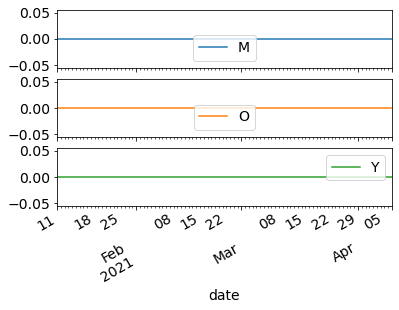

In [58]:
mydata[(mydata['comp'].isin(['vacc']))].groupby(['date','cat'])['value'].sum().reset_index('cat').pivot(columns='cat', values='value').cumsum().plot(subplots=True)

In [66]:
mydata[(mydata['comp'].isin(states_names))].groupby(['date','cat'])['value'].sum().reset_index('cat').pivot(columns='cat', values='value').loc['2021-01-11']-mydata[(mydata['comp'].isin(states_names))].groupby(['date','cat'])['value'].sum().reset_index('cat').pivot(columns='cat', values='value').iloc[-1]

cat
M    32833.003267
O    72396.336315
Y      264.168770
dtype: float64

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

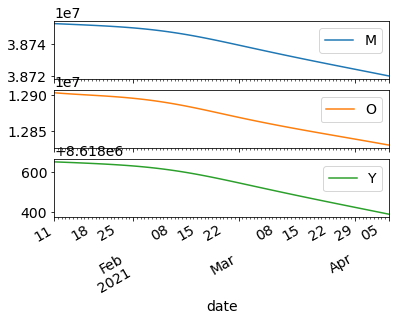

In [59]:
mydata[(mydata['comp'].isin(states_names))].groupby(['date','cat'])['value'].sum().reset_index('cat').pivot(columns='cat', values='value').plot(subplots=True)

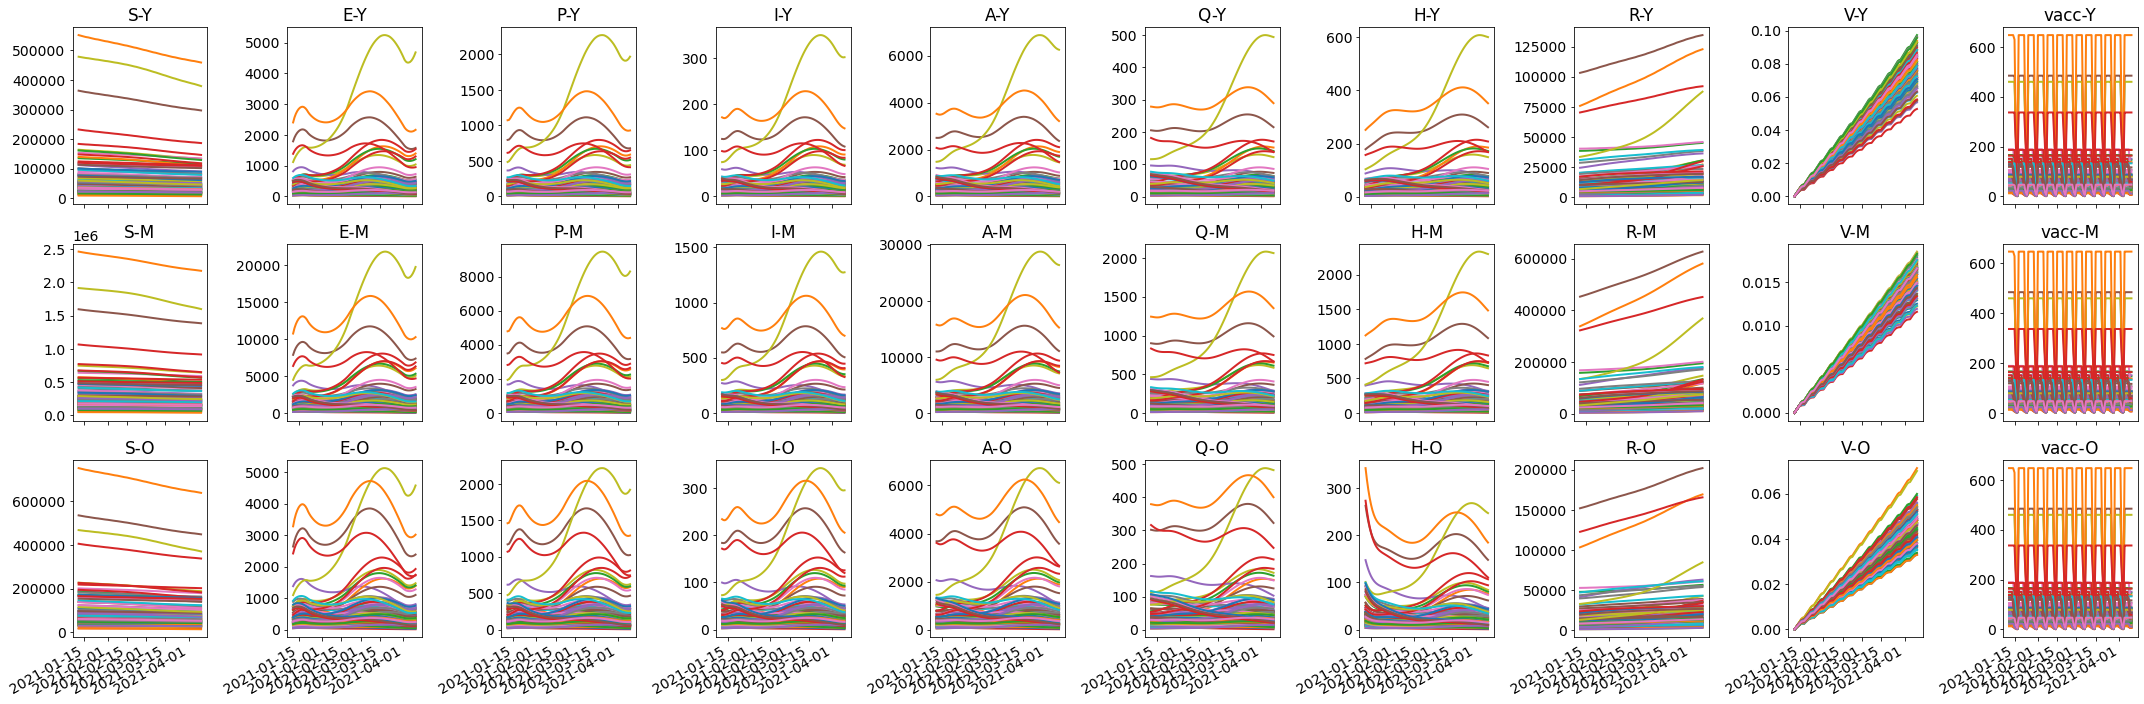

In [72]:
fig, axes = plt.subplots(3,10, figsize = (30,10), sharex=True)

value = 'value'
for i, st in enumerate(states_names + ["vacc"]):
    for ag_id, ag in enumerate(ages_names):
        axes[ag_id,i].plot(mydata[(mydata['comp'] == st) & (mydata['cat'] == ag)].pivot(columns = 'place', values=value), lw = 2, ls = '-')
        axes[ag_id,i].set_title(f"{st}-{ag}")
fig.autofmt_xdate()
fig.tight_layout()

In [53]:
G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}
setup.shp['vacc'] = np.nan
setup.shp['Rend'] = np.nan
for i, node in enumerate(setup.ind2name):
    G.add_node(node)
    G.position[node] = (setup.pos_node[i,0], setup.pos_node[i,1])
    G.population[node] = setup.pop_node_ag[i]
    #G.comp[node] = (ocp.ic['S'][i], ocp.ic['I'][i],ocp.ic['R'][i])
    
    G.epi[node] = {'vacc':md[(md['place']==node) & (md['comp']=='vacc')].pivot(columns = 'cat', values = 'value').sum(),
                   'Rend':  md[(md['place']==node) & (md['comp']=='R')].pivot(columns = 'cat', values = 'value').iloc[-1],
                   'NdayV': len(md[(md['place']==node) & (md['comp']=='vacc') & (md['value']>100)]),
                   'Infected':  md[(md['place']==node) & md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()}
    setup.shp.loc[i, 'vacc'] = md[(md['place']==node) & (md['comp']=='vacc')]['value'].sum()
    setup.shp.loc[i, 'Rend'] = md[(md['place']==node) & (md['comp']=='R')]['value'][-1]
    setup.shp.loc[i, 'NdayV'] = len(md[(md['place']==node) & (md['comp']=='vacc') & (md['value']>100)])
    setup.shp.loc[i, 'Infected'] =  md[(md['place']==node) & md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()
        
    setup.shp.loc[i, 'population'] =  setup.pop_node[i] # overwrite 
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=connection)
G.number_of_edges()

25

In [72]:
md[(md['place']==node) & (md['comp']=='vacc')].pivot(columns = 'cat', values = 'value').iloc[-1]

cat
M    3.509474e-08
O    3.509550e-08
Y    3.509469e-08
Name: 2021-01-30 00:00:00, dtype: float64

In [64]:
md[(md['place']==node) & (md['comp']=='vacc')].index.name

'date'

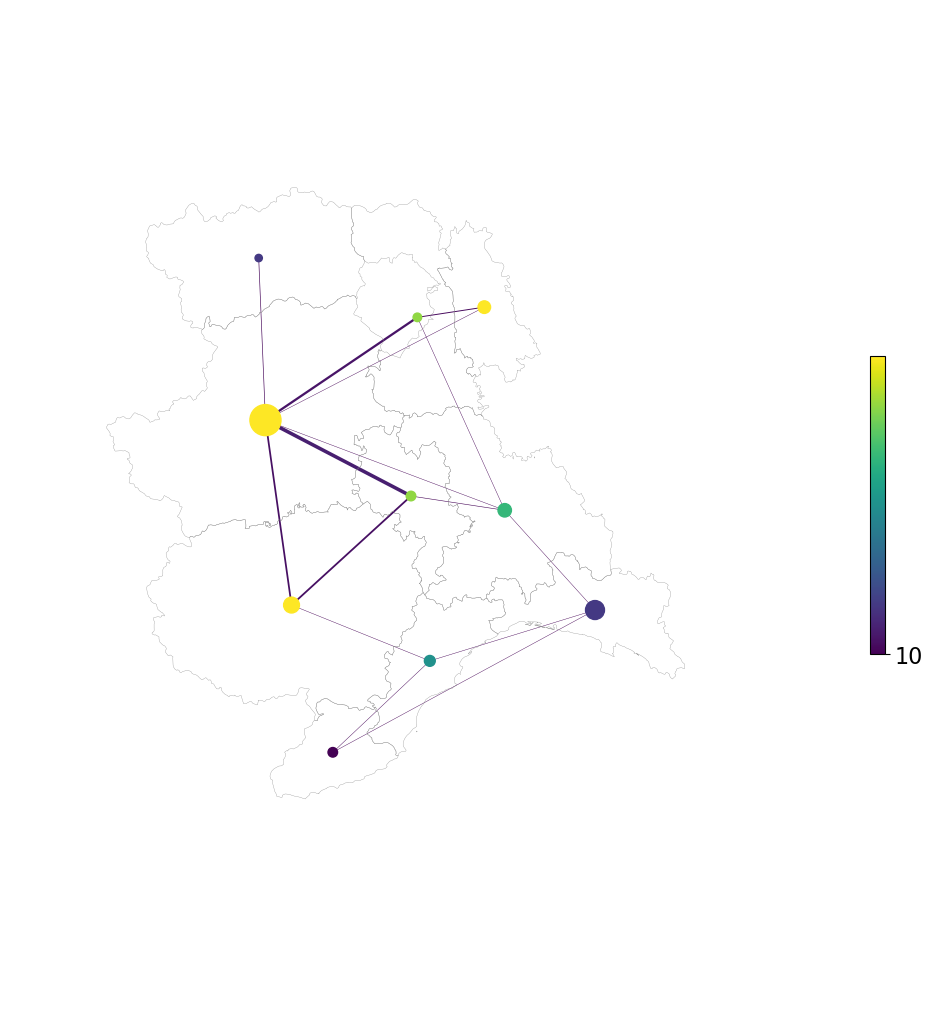

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi=100, constrained_layout=True) #


networkx.draw(G, 
          G.position, 
          node_size=500/max(setup.pop_node) * np.array([G.population[v] for v in G]),
          #node_color=[float(G.degree(v)) for v in G],
          #node_color=[G.population[v] for v in G],
          #node_color=[G.epi[v]['vacc']/G.population[v] for v in G],
          node_color= [G.epi[v]['NdayV'] for v in G],
          width = 30* np.array([max(a['weight'],0.01) for u,v,a in G.edges(data=True)]),
          edge_color= 10 * np.array([a['weight'] for u,v,a in G.edges(data=True)]),
          edge_cmap = mpl.cm.viridis,
        cmap = mpl.cm.viridis,
          ax = ax,
         with_labels=False
       )

#     # scale the axes equally
plt.xlim(min(setup.pos_node[:,0]) - 100000, max(setup.pos_node[:,0])+ 100000)
plt.ylim(min(setup.pos_node[:,1]) - 100000, max(setup.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

setup.shp.boundary.plot(ax = ax,  edgecolor="grey", linewidth = .21)


cmap = mpl.cm.viridis#sns.cm.rocket
vmin = min([G.epi[v]['NdayV'] for v in G])
vmax = max([G.epi[v]['NdayV'] for v in G])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []
cmap = fig.colorbar(sm, ax=ax, shrink=.3,  ticks=np.arange(0, vmax+10, 10),location = 'right')

cmap.ax.set_yticklabels(['{:.0f}'.format(x) for x in np.arange(0, vmax+10, 10)], fontsize=16)#, weight='bold')

plt.draw()

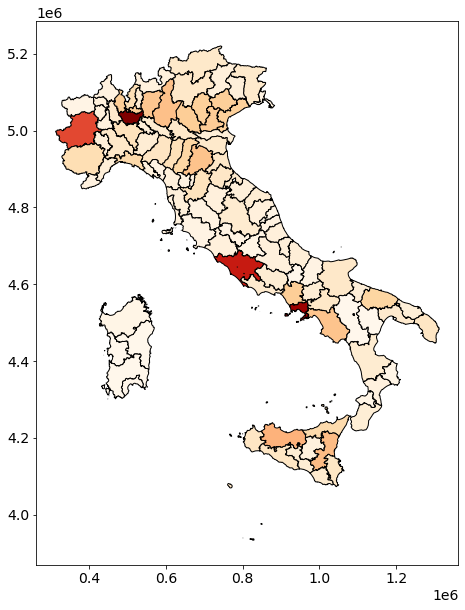

In [144]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
setup.shp.plot(ax = ax, column='vacc', cmap='OrRd',  edgecolor="black"); #facecolor="none",

(0.0, 20.407848954700984)

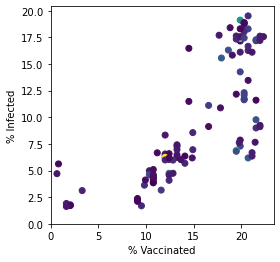

In [76]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(setup.shp['vacc']/setup.shp['population']*100, setup.shp['Infected']/setup.shp['population']*100, c= setup.shp['population'])
ax.set_xlabel("% Vaccinated")
ax.set_ylabel("% Infected");
ax.set_xlim(0)
ax.set_ylim(0)

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


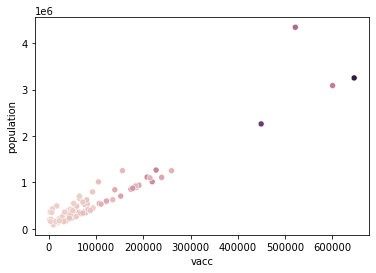

In [33]:
ax = sns.scatterplot(setup.shp['vacc'], setup.shp['population'], hue=setup.shp['Rend'])
ax.get_legend().remove();
#ax.set(xscale="log", yscale="log")

[None, None]

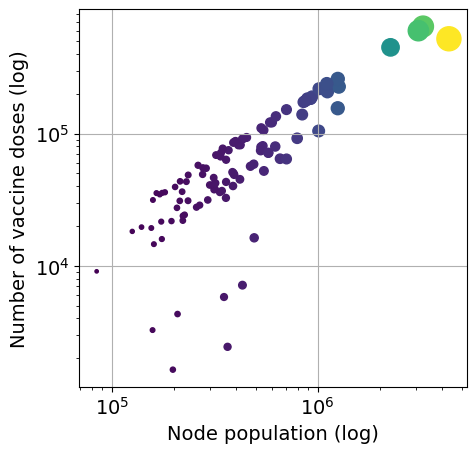

In [102]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['population'],
           setup.shp['vacc'], 
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
ax.set_ylabel('Number of vaccine doses (log)')
ax.set_xlabel('Node population (log)')
ax.set(xscale="log", yscale="log")

Text(0, 0.5, '% infected')

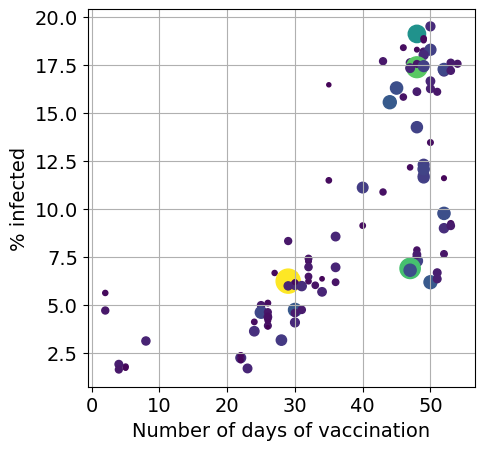

In [98]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['NdayV'], 
           setup.shp['Infected']/setup.shp['population']*100, 
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
ax.set_xlabel('Number of days of vaccination')
ax.set_ylabel('% infected')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


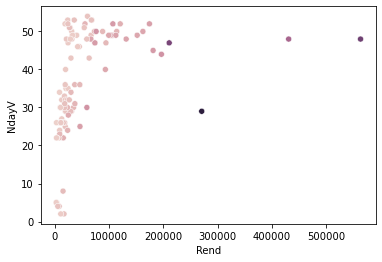

In [27]:
ax = sns.scatterplot(setup.shp['Rend'], setup.shp['NdayV'], hue=setup.shp['population'])
ax.get_legend().remove();

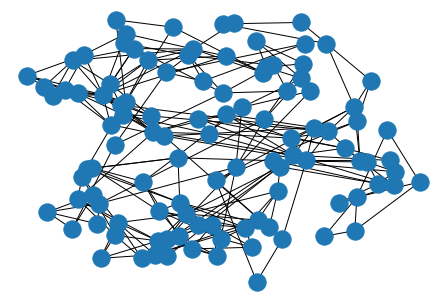

In [9]:
grph = networkx.from_numpy_matrix(p.mobmat_pr)
networkx.draw(grph)

In [39]:
setup.shp['Infected']

0      5.099525e+08
1      5.099525e+08
2      5.099525e+08
3      5.099525e+08
4      5.099525e+08
           ...     
102    5.099525e+08
103    5.099525e+08
104    5.099525e+08
105    5.099525e+08
106    5.099525e+08
Name: Infected, Length: 107, dtype: float64

In [75]:
pd.date_range('2020-02-01', '2020-02-06')

DatetimeIndex(['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06'],
              dtype='datetime64[ns]', freq='D')